In [598]:
import pandas as pd
import numpy as np
from scipy.stats import bernoulli
from numba import jit
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [599]:
data = pd.read_excel(rf"C:\Users\samir\Desktop\TAR-DT\a_close_final\data\data_final.xlsx")

In [600]:
data.columns = ['timestamp', 'rv_d', 'rv_w', 'rv_m', 'returns', 'volume']
data.set_index("timestamp", inplace=True)
data = data

In [601]:
data_num = data[['rv_d', 'rv_w', 'rv_m']].to_numpy()
rv_d = data_num[:,0]
rv_w = data_num[:, 1]
rv_m = data_num[:, 2]

In [602]:
import numpy as np
from numba import jit

@jit(nopython=True, fastmath=True)
def evaluate_performance_har(rv_d, rv_m, rv_w, x):
    """
    Evaluate the performance of a binary classifier using HAR model in each regime.

    Args:
        rv_d (np.ndarray): Daily realized volatility (target and predictor).
        rv_m (np.ndarray): Monthly realized volatility.
        rv_w (np.ndarray): Weekly realized volatility.
        x (np.ndarray): Binary classifier predictions (regime indicators).

    Returns:
        tuple: (ssr, phi)
            ssr (float): Sum of squared residuals from the HAR model.
            phi (np.ndarray): Estimated coefficients for both regimes.
    """
    T = len(rv_d)
    
    # Create design matrix Y for HAR model
    Y = np.column_stack((np.ones(T-1), rv_d[:-1], rv_w[:-1], rv_m[:-1]))
    
    # Target variable
    y = rv_d[1:]
    
    # Estimate coefficients for two regimes (k=0 and k=1)
    phi = np.zeros((2, 4))
    for k in range(2):
        mask = (x == k)
        Y_k = Y[mask]
        y_k = y[mask]
        if len(y_k) > 0:
            phi[k] = np.linalg.lstsq(Y_k, y_k)[0]
    
    # Calculate and return sum of squared residuals
    residuals = y - np.sum(Y * phi[x], axis=1)
    ssr = np.sum(residuals**2)
    
    return ssr, phi

# # Create a single realization of binary regime array x (with values 0 or 1)
# x = np.random.choice([0, 1], size=len(rv_d)-1)
# print(x)
# # Test the evaluate_performance_har function
# ssr, coefficients = evaluate_performance_har(rv_d,rv_w, rv_m, x)

# print(f"Sum of Squared Residuals: {ssr}")
# print(f"Coefficients:\nRegime 0: {coefficients[0]}\nRegime 1: {coefficients[1]}")

In [603]:
import numpy as np
from scipy.stats import bernoulli

def estimate_hidden_states(rv_d, rv_m, rv_w, q, N, rho, omega, max_iter=100, tol=1e-6):
    """
    Estimate hidden states using a genetic algorithm approach.

    Args:
        rv_d (np.ndarray): Daily realized volatility.
        rv_m (np.ndarray): Monthly realized volatility.
        rv_w (np.ndarray): Weekly realized volatility.
        q (int): Lag order for the regression.
        N (int): Number of samples to generate in each iteration.
        rho (float): Quantile threshold for selecting elite samples.
        omega (float): Mixing factor for updating probabilities.
        max_iter (int): Maximum number of iterations.
        tol (float): Convergence tolerance.

    Returns:
        tuple: (estimated_states, probabilities, best_performance)
            estimated_states (np.ndarray): Estimated hidden binary states (0 or 1).
            probabilities (np.ndarray): Final probabilities for each state.
            best_performance (tuple): Best performance metrics from evaluate_performance_har.
    """
    T = len(rv_d) - q
    p = np.full(T, 0.5)  # Initialize probabilities
    gammas = [0] * 10
    
    for _ in range(max_iter):
        # Generate samples and evaluate performance
        X = bernoulli.rvs(p, size=(N, T))
        S = np.array([evaluate_performance_har(rv_d, rv_m, rv_w, x)[0] for x in X])
        
        # Select elite samples
        gamma = np.percentile(S, rho * 100)
        gammas.append(gamma)
        elite_samples = X[S <= gamma]
        
        # Update probabilities
        p_new = np.mean(elite_samples, axis=0)
        p = omega * p_new + (1 - omega) * p
        
        # Check for convergence
        if (np.all(np.abs(p - 0.5) > 0.5 - tol)) or (gammas[-1] == gammas[-2] == gammas[-3] == gammas[-4]):
            best_x = X[S == min(S)][0]
            estimated_states = np.append([np.nan]*q, (p > 0.5).astype(int))
            probabilities = np.append([np.nan]*q, p)
            best_performance = evaluate_performance_har(rv_d, rv_m, rv_w, best_x)
            return estimated_states, probabilities, best_performance
    
    # If max_iter is reached without convergence
    best_x = X[S == min(S)][0]
    estimated_states = np.append([np.nan]*q, (p > 0.5).astype(int))
    probabilities = np.append([np.nan]*q, p)
    best_performance = evaluate_performance_har(rv_d, rv_m, rv_w, np.append([0]*q, best_x))
    return estimated_states, probabilities, best_performance

In [604]:
def informative_states(prob, pi):
    """
    Identify informative states based on probability values and a retention criterion.

    This function selects a subset of states considered informative based on their
    probability values and a specified retention ratio. It uses entropy as a measure
    of informativeness and returns binary indicators for the selected states.

    Parameters:
    ----------
    prob : np.ndarray
        An array of probabilities for different states.
    pi : float
        The retention ratio, determining the proportion of states to keep.
    y : np.ndarray
        A target array used for determining the number of retained states.
    q : integer
        The order of the autoregressive process. Due to the loss of the first q observations in AR(q) we have to add them to index.

    Returns:
    -------
    np.ndarray
        An array of binary values indicating informative states, where 1 indicates
        the state is considered informative (probability > 0.5) and 0 otherwise.

    Notes:
    -----
    - The function uses entropy (prob * (1 - prob)) as a measure of informativeness.
    - Lower entropy values are considered more informative.
    - The number of retained states is calculated as ceil(pi * len(y)).
    """
    # Calculate the number of states to retain
    retained = np.ceil(pi * len(prob)).astype(int)

    # Calculate the entropy of each state
    entropy = prob * (1 - prob)

    # Get the indices of the retained states (lowest entropy)
    indices = np.argpartition(entropy, retained)[:retained]

    # Sort the indices to maintain original order
    sorted_indices = np.sort(indices)

    # Return binary indicators for the retained states align it with index of the original series y:
    # you have 2 minus q when you want to slice state_est
    return np.sort(indices)

# Start Simulations

### Classification Stage - CE

In [606]:
# Assuming rv_d, rv_m, and rv_w are your input arrays
q = 1  # Example lag order
N = 60000  # Example number of samples
rho = 0.001  # Example quantile threshold
omega = 0.7  # Example mixing factor

# Use the first 200 observations to get the state estimates for the digression model:
estimated_states, probabilities, best_performance = estimate_hidden_states(rv_d, rv_m, rv_w, q, N, rho, omega)

# print("Estimated States:", estimated_states)
# print("Probabilities:", probabilities)
# print("Best Performance - SSR:", best_performance[0])
# print("Best Performance - Coefficients:", best_performance[1])

In [979]:
N_train = 200
N_valid = 400

In [980]:
indices_train = informative_states(probabilities[:N_train], 0.8)
indices_valid = informative_states(probabilities[N_train:N_valid], 0.8)+N_train
indices_train

array([  1,   2,   3,   4,   7,   8,   9,  10,  11,  14,  15,  16,  17,
        18,  20,  21,  22,  23,  24,  25,  28,  30,  31,  32,  34,  36,
        37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,
        50,  51,  52,  53,  54,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  74,  77,  78,  79,
        80,  81,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 105, 106, 107,
       108, 109, 112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 134, 135, 136, 137, 138,
       140, 141, 142, 143, 144, 147, 148, 149, 150, 151, 153, 155, 157,
       158, 159, 161, 164, 165, 166, 167, 168, 169, 172, 173, 174, 175,
       176, 178, 179, 180, 181, 184, 185, 186, 187, 191, 192, 193, 194,
       196, 197, 198, 199], dtype=int64)

In [981]:
retained_states_train = estimated_states[indices_train]
retained_states_valid = estimated_states[indices_valid]
retained_states_train, retained_states_valid

(array([1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1.,
        0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0.,
        1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1.,
        1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
        1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1.

# Run OLS To Get Coefficients

In [982]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

har_features = pd.DataFrame()
har_features["rv_d"] = rv_d[:N_train]
har_features["rv_w"] = rv_w[:N_train]
har_features["rv_m"] = rv_m[:N_train]
har_features = har_features.shift(1)

# Assuming rv_d is your daily realized volatility series
rv_df = pd.Series(rv_d[:N_train])  # Convert to pandas Series if it's not already

# Create dummy variables for states
# Assuming 'x' is your binary state indicator (0 or 1)
dummyv = pd.get_dummies(retained_states_train, prefix='State')

# Combine HAR features and dummy variables
X = pd.concat([har_features, dummyv], axis=1)
X["rv_df"] = rv_df
# Prepare the dependent variable
for har_col in har_features.columns:
    for state_col in dummyv.columns:
        X[f'{har_col}_{state_col}'] = X[har_col] * X[state_col]

# Add a constant term
X = sm.add_constant(X).dropna()
y = X["rv_df"]
X.drop(columns=["rv_df", "rv_d", "rv_m", "rv_w", "const"], inplace = True)

In [983]:
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  rv_df   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     14.84
Date:                Sun, 06 Oct 2024   Prob (F-statistic):           1.20e-14
Time:                        04:52:59   Log-Likelihood:                -463.29
No. Observations:                 159   AIC:                             942.6
Df Residuals:                     151   BIC:                             967.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
State_0.0          0.0488      2.745      0.

# Data Split and Classification Stage

In [984]:
# Step 1: Create features from the time series y
def create_features(y):
    name = y.name
    features = pd.DataFrame({
        rf'{name}_3Yt-3 - 2Y^2_t-2': 3*y.shift(3) - 2*y.shift(2)**2,
        rf'{name}_Yt-1': y.shift(1),
        rf'{name}_Yt-2': y.shift(2),
        rf'{name}_Yt-3': y.shift(3),
        rf'{name}_Yt-4': y.shift(4),
        rf'{name}_Y^3_t-1 - 13Yt-2 + 14': y.shift(1)**3 - 13*y.shift(2) + 14,
        rf'{name}_Y^2_t-2 - 11Yt-3 + 77': y.shift(2)**2 - 11*y.shift(3) + 77,
        rf'{name}_Y^3_t-3 - 17Yt-4 + 66': y.shift(3)**3 - 17*y.shift(4) + 66,
        rf'{name}_5U[1,0]': np.random.uniform(1, 0, len(y)) * 5,
        rf'{name}_2N(0,1) + 3U[0,1]': 2*np.random.normal(0, 1, len(y)) + 3*np.random.uniform(0, 1, len(y)),
        rf'{name}_Y^4_t-1 + 2Yt-1 + 8N(0,1)': y.shift(1)**4 + 2*y.shift(1) + 8*np.random.normal(0, 1, len(y)),
        rf'{name}_Y^4_t-3 + 3Yt-3 + 4N(0,1)': y.shift(3)**4 + 3*y.shift(3) + 4*np.random.normal(0, 1, len(y)),
        rf'{name}_Y^3_t-1 + 4Yt-1 + 3N(0,1)': y.shift(1)**3 + 4*y.shift(1) + 3*np.random.normal(0, 1, len(y)),
        rf'{name}_Y^2_t-2 + 5Yt-3 + 6N(0,1)': y.shift(2)**2 + 5*y.shift(3) + 6*np.random.normal(0, 1, len(y)),
        rf'{name}_Y^2_t-3 + 6Yt-3 + 7N(0,1)': y.shift(3)**2 + 6*y.shift(3) + 7*np.random.normal(0, 1, len(y)),
        rf'{name}_Y^2_t-2 + 7Yt-2 + 4N(0,1)': y.shift(2)**2 + 7*y.shift(2) + 4*np.random.normal(0, 1, len(y)),
        rf'{name}_Y^3_t-3 + 8Yt-3 + 8N(0,1)': y.shift(3)**3 + 8*y.shift(3) + 8*np.random.normal(0, 1, len(y)),
        rf'{name}_Y^3_t-3 + 9Yt-3 + 3N(0,1)': y.shift(3)**3 + 9*y.shift(3) + 3*np.random.normal(0, 1, len(y)),
        rf'{name}_Y^3_t-3 + 10Yt-3 + 2N(0,1)': y.shift(3)**3 + 10*y.shift(3) + 2*np.random.normal(0, 1, len(y)),
        rf'{name}_Y^2_t-2 + 11Yt-2 + 4N(0,1)': y.shift(2)**2 + 11*y.shift(2) + 4*np.random.normal(0, 1, len(y))
    })
    return features

In [985]:
rv_new = data["rv_d"]
dat = data.shift(1)
dat["rv_flag"] = rv_new
dat["states"] = estimated_states
# datt = pd.concat([create_features(dat.rv_d), create_features(dat.rv_m), create_features(dat.rv_w), create_features(dat.volume), create_features(dat.returns)], axis = 1)

In [986]:
# dat = pd.concat([dat, datt], axis = 1).dropna()
# dat = data.dropna()
dat

,rv_d,rv_w,rv_m,returns,volume,rv_flag,states
timestamp,,,,,,,
2023-01-31,NaN,NaN,NaN,NaN,NaN,3.618131,NaN
2023-02-01,3.618131,5.078403,6.092091,1.301310,264649.34909,5.385635,1.0
2023-02-02,5.385635,4.353663,6.241618,2.593225,310790.42271,7.882679,1.0
2023-02-03,7.882679,4.930218,6.481974,-1.032249,364177.20751,3.719638,1.0
2023-02-04,3.719638,4.649991,6.562119,-0.243133,332571.02904,1.251661,1.0
...,...,...,...,...,...,...,...
2024-09-29,1.080738,3.603085,5.568050,0.133786,9127.23316,0.990325,0.0
2024-09-30,0.990325,3.356390,5.387618,-0.389457,8337.74111,4.731435,1.0
2024-10-01,4.731435,3.309243,5.513317,-3.528524,30011.08752,7.738511,1.0


In [987]:
X_retained = dat.iloc[indices_train, ~dat.columns.isin(["states", "rv_flag"])]
y_retained = dat.iloc[indices_train, dat.columns == "states"]
X_valid    = dat.iloc[N_train:N_valid, ~dat.columns.isin(["states", "rv_flag"])]
y_valid    = dat.iloc[N_train:N_valid, dat.columns=="states"]   
X_test     = dat.iloc[N_valid:, ~dat.columns.isin(["states", "rv_flag"])]
y_test     = dat.iloc[N_valid:, dat.columns=="states"]   

# Data Process for Search Stage

In [988]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from IPython.display import display, Markdown

# DT algorithm

In [997]:
y_valid.iloc[indices_valid-N_train]

,states
timestamp,
2023-08-19,1.0
2023-08-20,0.0
2023-08-21,0.0
2023-08-22,0.0
2023-08-23,0.0
...,...
2024-03-01,1.0
2024-03-02,1.0
2024-03-03,0.0


In [999]:
# Step 2: Fit decision tree using cost-complexity pruning and time series validation
def fit_optimal_tree(X_retained, y_retained, X_valid, y_valid):
    # Fit the initial tree
    clf = DecisionTreeClassifier(random_state=42, criterion="entropy", class_weight={0:1, 1:2})
    path = clf.cost_complexity_pruning_path(X_retained, y_retained)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    
    # Train trees with different alphas
    clfs = []
    for ccp_alpha in ccp_alphas:
        clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha, criterion="entropy")
        clf.fit(X_retained, y_retained)
        clfs.append(clf)
    
    # Validate and choose the best alpha
    acc_scores = [accuracy_score(y_valid.iloc[indices_valid-N_train], clf.predict(X_valid.iloc[indices_valid-N_train])) for clf in clfs]
    best_alpha_idx = np.argmax(acc_scores)
    plt.figure(figsize=(20,10))
    plot_tree(clfs[best_alpha_idx], 
          feature_names=X_retained.columns,  
          class_names=["0", "1"],
          filled=True, 
          rounded=True)
    plt.show()
    return clfs[best_alpha_idx]

# Fit the optimal tree
optimal_tree = fit_optimal_tree(X_retained, y_retained, X_valid.iloc[indices_valid-N_train], y_valid.iloc[indices_valid-N_train])

# Step 3: Forecast the test set
y_pred_test = optimal_tree.predict(X_test)

# Print feature importances
importances = pd.Series(optimal_tree.feature_importances_, index=X_valid.columns).sort_values(ascending=False)
print("Feature Importances:")
print(importances)

# Print test set accuracy (assuming you have true labels for the test set)

test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Set Accuracy: {test_accuracy}")

# If you don't have true labels for the test set, you can just print the predictions
print("Test Set Predictions:")
print(y_pred_test)

IndexError: positional indexers are out-of-bounds

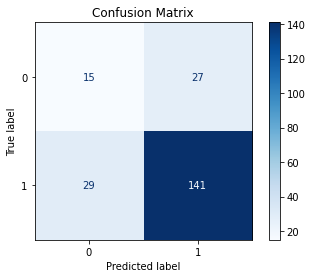

In [963]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()